In [5]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from utils import constants as cnst, u_darrays as uda
import salem
import xarray as xr
# Some defaults
cmap = plt.get_cmap('RdBu_r')
sns.set_context('talk')
sns.set_style('ticks')

In [4]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [6]:
#mcs = cnst.GRIDSAT_PERU + 'aggs/gridsat_WA_-40_allClouds_monthly.nc'
mcs = cnst.GRIDSAT_PERU + 'aggs/gridsat_WA_count_-50_allClouds_monthly.nc'

fpath = cnst.network_data + 'figs/HUARAZ/'

isbuffer = [-79, -74, -12, -7] #Altiplano: [-78, -65, -20, -12]

topo = xr.open_dataarray(cnst.TOPO_1MIN).sel(lon=slice(isbuffer[0], isbuffer[1]), lat=slice(isbuffer[2], isbuffer[3]))

da3 = xr.open_dataarray(mcs).sel(lon=slice(isbuffer[0], isbuffer[1]), lat=slice(isbuffer[2], isbuffer[3]))
topo_on_da3 = da3.salem.lookup_transform(topo)

da3 = da3.where(topo_on_da3>3000)

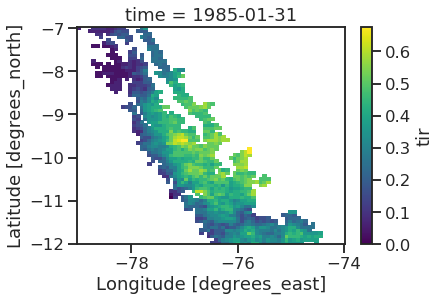

In [7]:
da3[0,:,:].plot()

In [8]:
da3 = da3.mean(['lat', 'lon'])*100

In [9]:
da3.time

<xarray.DataArray 'time' (time: 396)>
array(['1985-01-31T00:00:00.000000000', '1985-02-28T00:00:00.000000000',
       '1985-03-31T00:00:00.000000000', ..., '2017-10-31T00:00:00.000000000',
       '2017-11-30T00:00:00.000000000', '2017-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1985-01-31 1985-02-28 ... 2017-12-31

In [10]:
def readERA():

    u200orig = xr.open_dataset('/media/ck/Elements/SouthAmerica/ERA5/hourly/u_15UTC_1981-2019_peru_big.nc')
    u200orig = uda.flip_lat(u200orig)
    datetimes = pd.to_datetime(u200orig.time.values)
    newtimes = []
    for t in datetimes:
        newtimes.append(t.replace(hour=0))
    u200orig['time'] = ('time', newtimes)
    return u200orig

In [11]:
era = readERA()
era = era.sel(longitude=slice(isbuffer[0], isbuffer[1]), latitude=slice(isbuffer[2], isbuffer[3]))

In [12]:
era_valley = era.mean(['latitude', 'longitude'])

In [13]:
era_valley.time

<xarray.DataArray 'time' (time: 14610)>
array(['1979-01-01T00:00:00.000000000', '1979-01-02T00:00:00.000000000',
       '1979-01-03T00:00:00.000000000', ..., '2018-12-29T00:00:00.000000000',
       '2018-12-30T00:00:00.000000000', '2018-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    level    int32 ...
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2018-12-31

In [14]:
posgrid = np.intersect1d(era_valley.time.values, da3.time.values)

gsat = da3.sel(time=posgrid)
era_valley = era_valley.sel(time=posgrid)

# posgrid = np.intersect1d(era_valley.time.values, ca.time.values)
# chirp = ca.sel(time=posgrid)

In [15]:
era_valley

<xarray.Dataset>
Dimensions:  (time: 396)
Coordinates:
    level    int32 ...
  * time     (time) datetime64[ns] 1985-01-31 1985-02-28 ... 2017-12-31
Data variables:
    u        (time) float32 -2.9585392 -9.026636 ... -3.0444443 -12.872743

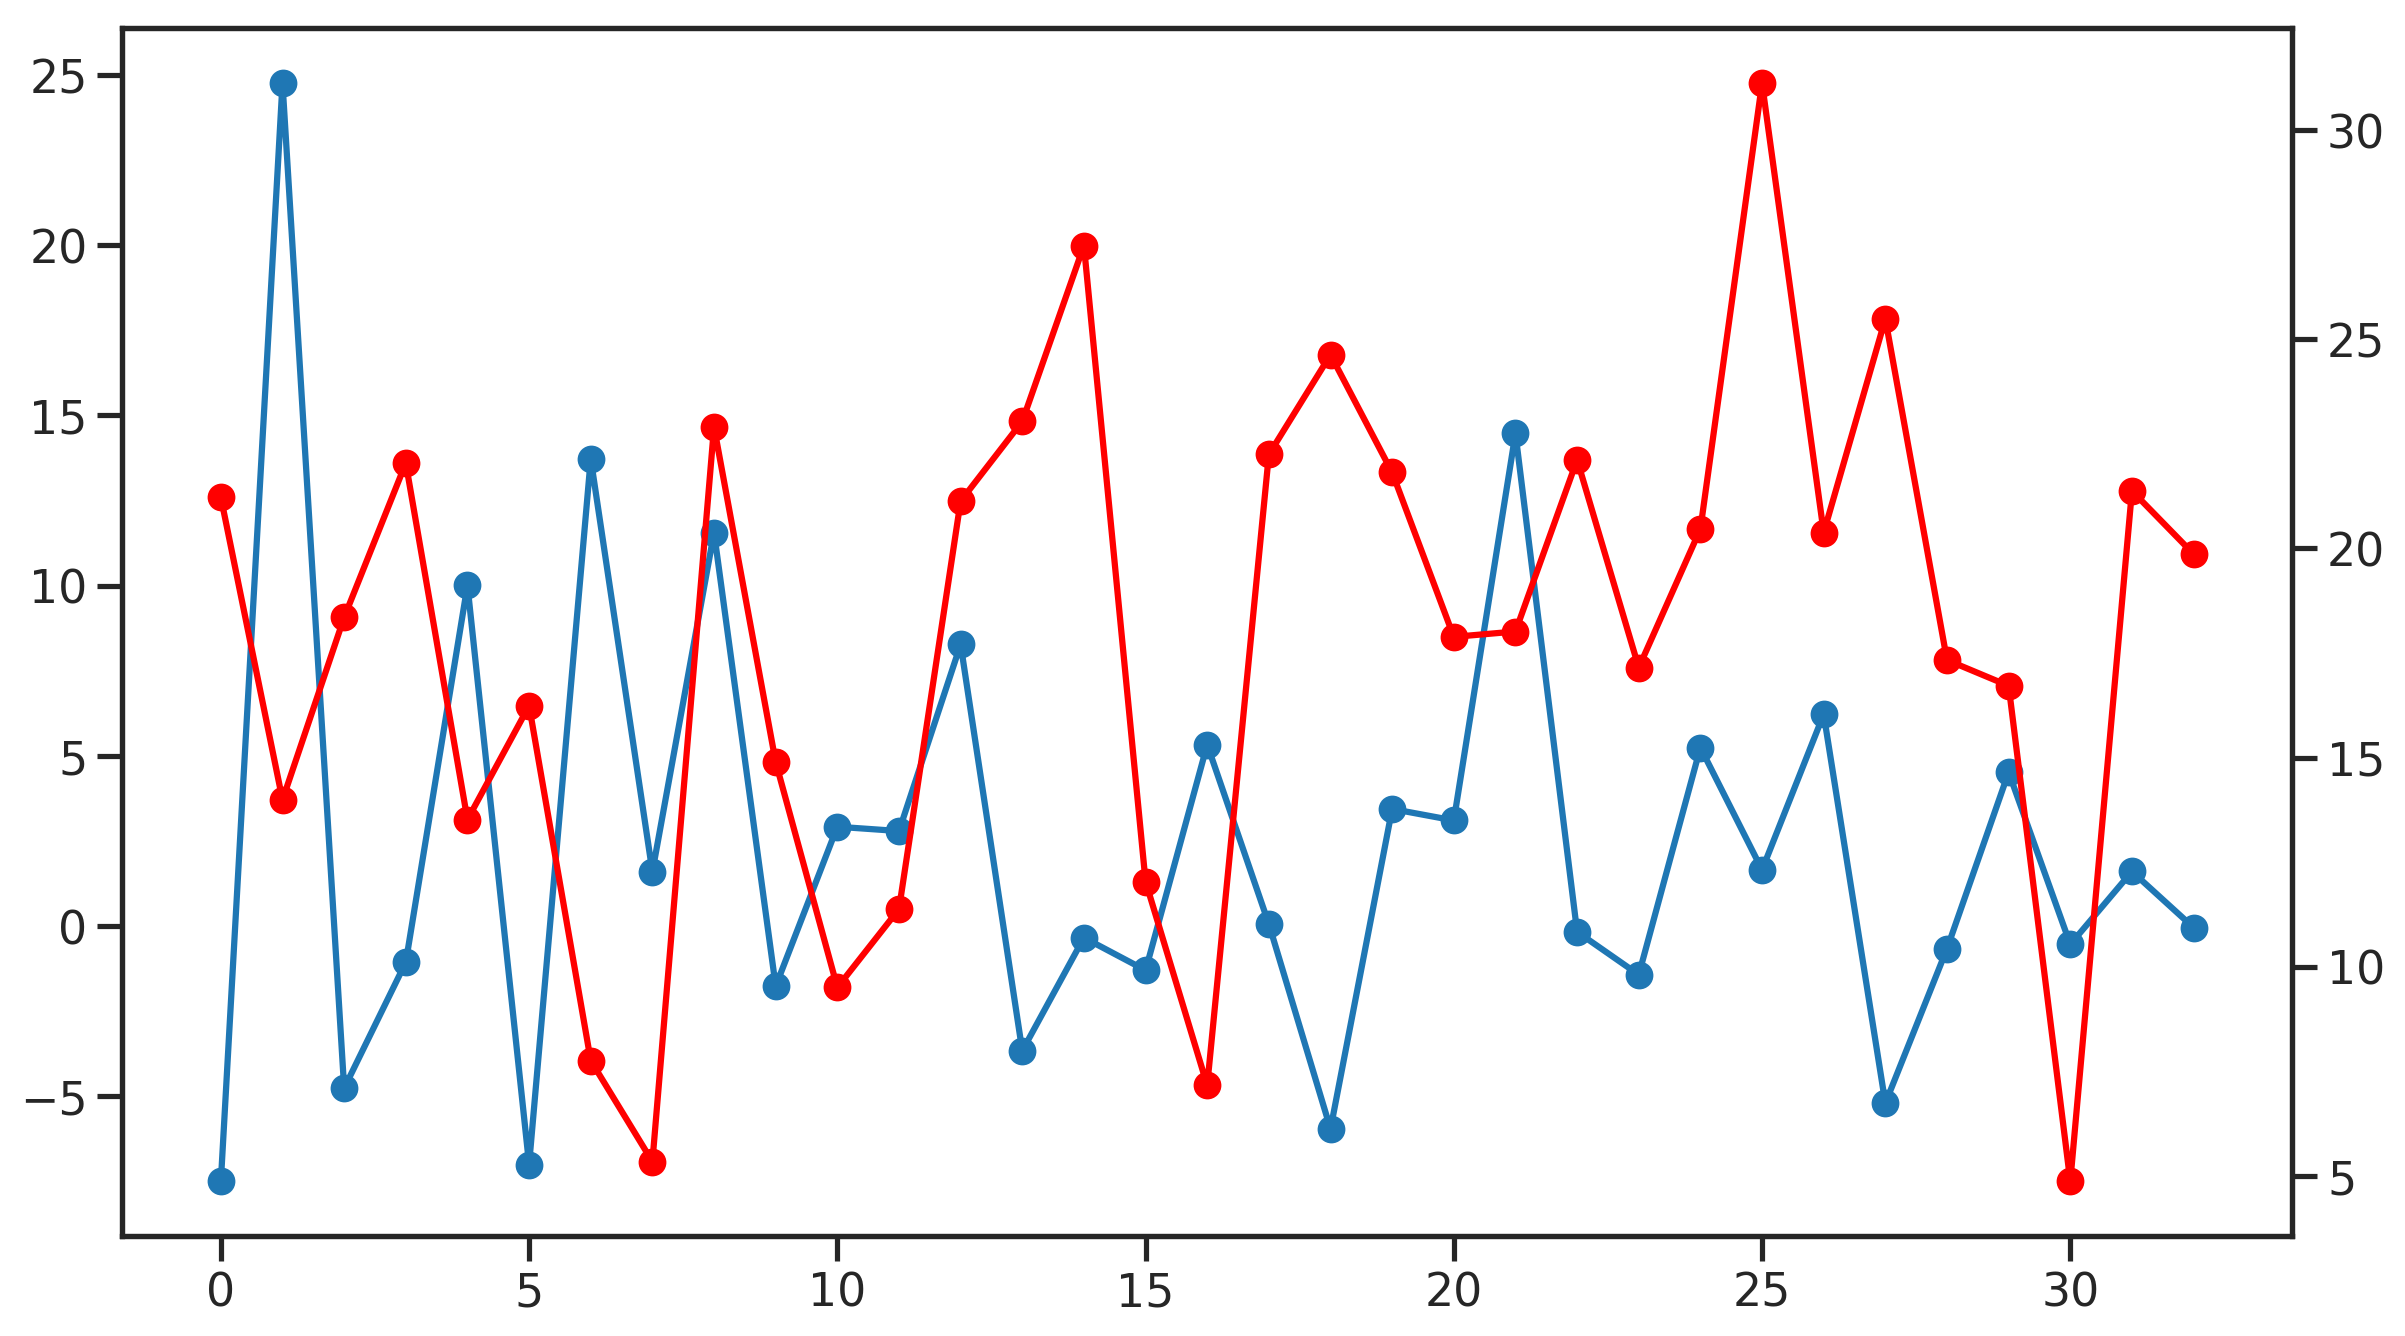

In [16]:
f=plt.figure(figsize=(14,8), dpi=200)
ax = f.add_subplot(111)
ax.plot(era_valley['u'].sel(time=(era_valley['time.month']==4)), marker='o')
ax1 = ax.twinx()
ax1.plot(gsat.sel(time=(gsat['time.month']==12)), color='r', marker='o')

In [25]:
months= [1,2,3,4,5,6,7,8,9,10,11,12]#,4,5,6,9,10,11#,4,5,6,9,10,11,(3,5), (9,11)]#, 10,5,9]#[(12,2)]#[1,2,3,4,5,6,7,8,9,10,11,12]# #,2,3,11,12]#[(12,2)]#[1,2,3,4,5,6,7,8,9,10,11,12]# #,2,3,11,12]
m=11

# ets = era_valley['u'].sel(time=(era_valley['time.month']==m))
# gts = gsat.sel(time=(gsat['time.month']==m))

ets = era_valley['u'].sel(time=((era_valley['time.month']==12) | (era_valley['time.month']<=2))).groupby('time.year').mean('time')
gts = gsat.sel(time=((gsat['time.month']==12) | (gsat['time.month']<=2))).groupby('time.year').mean('time')
#cts = chirp.sel(time=((chirp['time.month']==12) | (chirp['time.month']<=2))).groupby('time.year').mean('time')
dicm = {}
dicmean = {}

In [26]:
ets = ets.to_pandas()
gts = gts.to_pandas()

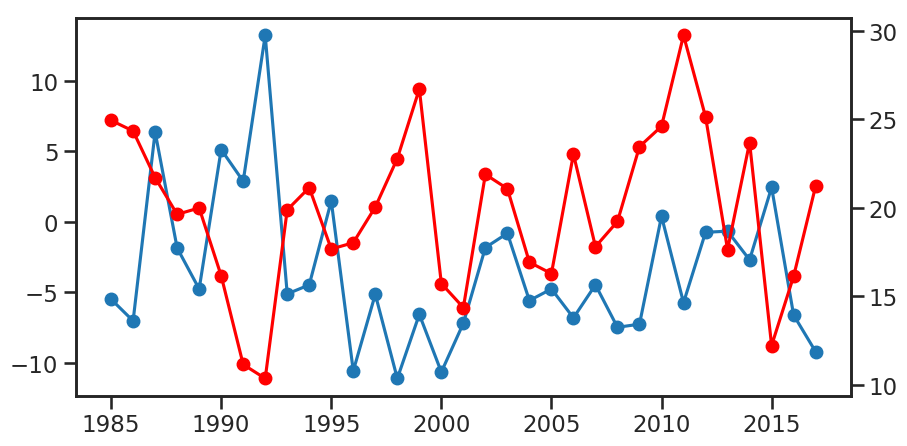

In [27]:
f=plt.figure(figsize=(10,5), dpi=100)
ax = f.add_subplot(111)
ax.plot(ets, marker='o')
ax1 = ax.twinx()
ax1.plot(gts, color='r', marker='o')

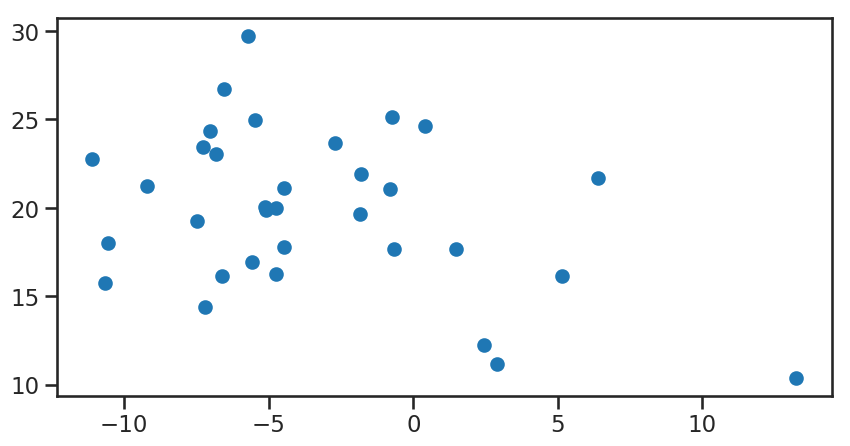

In [28]:
f=plt.figure(figsize=(10,5), dpi=100)
ax = f.add_subplot(111)
plt.scatter(ets,gts)

### Trend analysis 

In [34]:
# the trend are computed on time series at least 20yrs long
start_years = ets.index[:-5]
end_years = ets.index[5:]
ny = len(start_years)
extent = (start_years[0], start_years[-1], end_years[0], end_years[-1])  # needed for the plot later

In [40]:
# fill the triangle
trend = np.zeros((ny, ny)) * np.NaN
sig = np.ones((ny, ny)) 
for i, start_year in enumerate(start_years):
    for j, end_year in enumerate(end_years):
        data1 = ets.loc[start_year:end_year]
        data2 = gts.loc[start_year:end_year]
        if len(data1) < 5:
            continue
        slope, intercept, r, p_val, stderr = stats.linregress(data1.values, data2.values)
        trend[j, i] = r   # for decadal trends
        sig[j, i] = p_val

### Plot 

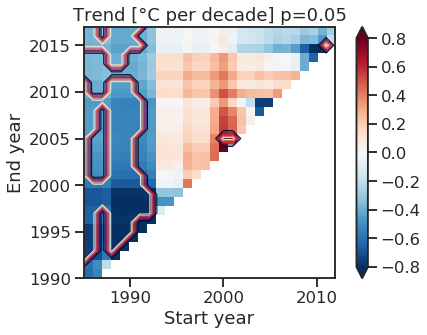

In [41]:
# plot
plt.figure(figsize=(7, 5))
im = plt.imshow(trend, extent=extent, interpolation='none', origin='lower', cmap=cmap, vmin=-0.8, vmax=0.8)
plt.contour(start_years, end_years, sig < 0.05, linewidths=1)
plt.colorbar(im, extend='both');
plt.title('Trend [°C per decade] p=0.05');
plt.xlabel('Start year');
plt.ylabel('End year');
plt.tight_layout()
#plt.savefig('triangle_giss.png', dpi=150)

In [9]:
print('{:.1%} of the triangle has a significant trend.'.format(np.sum(sig < 0.05) / np.sum(np.isfinite(trend))))

84.7% of the triangle has a significant trend.


## Random case 

We make a fake global temperature timeseries which has the same variance as the real one. We assume normality (which is far from reality...):

In [ ]:
np.random.seed(12)  # for reproducible results
fake_ts = pd.Series(np.random.normal(0., np.std(ts), len(ts)), index=ts.index)
ax = fake_ts.plot(figsize=(9, 5));
ax.set_ylabel('A random timeseries');
plt.tight_layout()
plt.savefig('ts_random.png', dpi=150)

In [ ]:
trend = np.zeros((ny, ny)) * np.NaN
sig = np.ones((ny, ny))
for i, start_year in enumerate(start_years):
    for j, end_year in enumerate(end_years):
        data = fake_ts.loc[start_year:end_year]
        if len(data) < 20:
            continue
        slope, _, _, p_val, _ = stats.linregress(data.index, data.values)
        trend[j, i] = slope * 10  # for decadal trends
        sig[j, i] = p_val

In [ ]:
# plot
plt.figure(figsize=(7, 5))
im = plt.imshow(trend, extent=extent, interpolation='none', origin='lower', cmap=cmap, vmin=-0.2, vmax=0.2)
plt.contour(start_years, end_years, sig < 0.05, linewidths=1)
plt.colorbar(im, extend='both');
plt.title('Trend [°C per decade] p=0.05');
plt.xlabel('Start year');
plt.ylabel('End year');
plt.tight_layout()
plt.savefig('triangle_random.png', dpi=150)

In [ ]:
print('{:.1%} of the triangle has a significant trend.'.format(np.sum(sig < 0.05) / np.sum(np.isfinite(trend))))

### "Extreme" example: 

In [ ]:
np.random.seed(0)  # for reproducible results
fake_ts = pd.Series(np.random.normal(0., np.std(ts), len(ts)), index=ts.index)
trend = np.zeros((ny, ny)) * np.NaN
sig = np.ones((ny, ny))
for i, start_year in enumerate(start_years):
    for j, end_year in enumerate(end_years):
        data = fake_ts.loc[start_year:end_year]
        if len(data) < 20:
            continue
        slope, _, _, p_val, _ = stats.linregress(data.index, data.values)
        trend[j, i] = slope * 10  # for decadal trends
        sig[j, i] = p_val
# plot
plt.figure(figsize=(7, 5))
im = plt.imshow(trend, extent=extent, interpolation='none', origin='lower', cmap=cmap, vmin=-0.2, vmax=0.2)
plt.contour(start_years, end_years, sig < 0.05, linewidths=1)
plt.colorbar(im, extend='both');
plt.title('Trend [°C per decade] p=0.05');
plt.xlabel('Start year');
plt.ylabel('End year');
plt.tight_layout()
plt.savefig('triangle_random_ex.png', dpi=150)
print('{:.1%} of the triangle has a significant trend.'.format(np.sum(sig < 0.05) / np.sum(np.isfinite(trend))))

## More systematic case: how often does this extreme case happen? 

We repeat the game a 1000 times and see how many percent of the triangle is "significant".

In [ ]:
def get_sig_ratio(in_ts):
    trend = np.zeros((ny, ny)) * np.NaN
    sig = np.ones((ny, ny))
    for i, start_year in enumerate(start_years):
        for j, end_year in enumerate(end_years):
            data = in_ts.loc[start_year:end_year]
            if len(data) < 20:
                continue
            slope, _, _, p_val, _ = stats.linregress(data.index, data.values)
            trend[j, i] = slope * 10  # for decadal trends
            sig[j, i] = p_val
    return len(np.nonzero(sig < 0.05)[0]) / np.sum(np.isfinite(trend))

In [ ]:
perc = []
np.random.seed(0)  # for reproducible results
# this can take *a while*, obviously
for _ in range(1000):
    fake_ts = pd.Series(np.random.normal(0., np.std(ts), len(ts)), index=ts.index)
    perc.append(get_sig_ratio(fake_ts))

In [ ]:
d = {'avg': np.average(perc), 'max': np.max(perc), 'nmore':np.sum(np.array(perc)>0.20)}
print('The average area of the significance is {avg:.1%}, and {nmore} of the 1000 runs have more then 20%.'.format(**d))

In [ ]:
# plot
plt.figure(figsize=(7, 5))
plt.hist(perc, bins=np.arange(45)*0.01);
plt.ylabel('Number of runs')
plt.xlabel('Area wich is significant (%)')
plt.tight_layout()
plt.savefig('hist_real.png', dpi=150)